# CPI Predictors
Which forward looking CPI estimates best predict actual CPI and Core CPI based on historical data from 1982? In this notebook I put the following ones to the test:
* `STICKCPIM158SFRBATL` &mdash; Sticky Price Consumer Price Index (aka Sticky CPI)
* `EXPINF1YR` &mdash; Federal Reserve Bank of Cleveland estimate of 1-Year Expected Inflation
* `MICH` &mdash; University of Michigan: Inflation Expectation over the next 12 months

I shift the respective Sticky CPI, Fed Reserve Bank of Cleveland 1-Year Expectated Inflation, and University of Muchigan inflation expectation publications by 1 to 12 months forward and take [the root mean square error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) between them and the actual CPI and core CPI in that month.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthBegin

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
cpis = web.get_data_fred(['CPIAUCSL', 'CPILFESL', 'STICKCPIM158SFRBATL', 'EXPINF1YR', 'MICH'], start=report_start, end=report_end)
cpis.iloc[:,2:] /= 100.
cpis.update(cpis.iloc[:,:2].pct_change(12))
cpis.dropna(inplace=True)

In [4]:
cpis

,CPIAUCSL,CPILFESL,STICKCPIM158SFRBATL,EXPINF1YR,MICH
DATE,,,,,
1982-01-01,0.082569,0.092506,0.045867,0.063945,0.051
1982-02-01,0.076136,0.091967,0.051390,0.064321,0.052
1982-03-01,0.068849,0.086806,0.002697,0.063877,0.042
1982-04-01,0.066218,0.088506,0.107083,0.061406,0.047
1982-05-01,0.069119,0.086560,0.132664,0.054882,0.035
...,...,...,...,...,...
2022-07-01,0.084821,0.059115,0.054373,0.033093,0.052
2022-08-01,0.082492,0.063171,0.077277,0.033771,0.048
2022-09-01,0.082224,0.066578,0.084895,0.041791,0.047


In [5]:
def rmse(series_diff):
    return np.sqrt((series_diff**2).mean())

In [6]:
def construct_rmse_dataframe(date_from=None):
    """
    :param date_from: a datetime.date or pandas.Timestamp object indicating if
                      the calculation of RMSE should be limited to the range of months starting from the given date
    """
    rmse_cpi = []
    rmse_core_cpi = []
    rmse_cpi_exp = []
    rmse_core_cpi_exp = []
    rmse_cpi_mich = []
    rmse_core_cpi_mich = []

    _cpis = cpis if date_from is None else cpis.loc[date_from:]
                   
    idx = pd.Index(range(1, 13), name='Sticky CPI/Expected Inflation forward shift in months')
    for i in idx:
        cpis_shifted = pd.concat([_cpis.iloc[:,:2], _cpis.iloc[:,2:].shift(i)], axis=1)
        rmse_cpi.append(rmse(cpis_shifted.iloc[:,0]-cpis_shifted.iloc[:,2]))
        rmse_core_cpi.append(rmse(cpis_shifted.iloc[:,1]-cpis_shifted.iloc[:,2]))
        rmse_cpi_exp.append(rmse(cpis_shifted.iloc[:,0]-cpis_shifted.iloc[:,3]))
        rmse_core_cpi_exp.append(rmse(cpis_shifted.iloc[:,1]-cpis_shifted.iloc[:,3]))
        rmse_cpi_mich.append(rmse(cpis_shifted.iloc[:,0]-cpis_shifted.iloc[:,4]))
        rmse_core_cpi_mich.append(rmse(cpis_shifted.iloc[:,1]-cpis_shifted.iloc[:,4]))
    
    return pd.DataFrame(np.array([rmse_cpi, rmse_core_cpi, rmse_cpi_exp, rmse_core_cpi_exp, rmse_cpi_mich, rmse_core_cpi_mich]).T,
                index=idx, columns=['RMSE CPI and Sticky CPI', 'RMSE Core CPI and Sticky CPI',
                                    'RMSE CPI and 1y Expected Infl', 'RMSE Core CPI and 1y Expected Infl',
                                    'RMSE CPI and Mich Infl Exp', 'RMSE Core CPI and Mich Infl Exp'])

In [7]:
df_cpi_predictors = construct_rmse_dataframe()
date_for_last_10y = report_end - relativedelta(years=+10) - MonthBegin()
date_for_last_5y = report_end - relativedelta(years=+5) - MonthBegin()
df_cpi_predictors_last_10y = construct_rmse_dataframe(date_for_last_10y)
df_cpi_predictors_last_5y = construct_rmse_dataframe(date_for_last_5y)

In [8]:
df_cpi_predictors

,RMSE CPI and Sticky CPI,RMSE Core CPI and Sticky CPI,RMSE CPI and 1y Expected Infl,RMSE Core CPI and 1y Expected Infl,RMSE CPI and Mich Infl Exp,RMSE Core CPI and Mich Infl Exp
Sticky CPI/Expected Inflation forward shift in months,,,,,,
1,0.014758,0.011737,0.012890,0.008375,0.012370,0.011549
2,0.015136,0.011792,0.013079,0.008305,0.012487,0.011282
3,0.015652,0.011968,0.013410,0.008393,0.012649,0.011078
4,0.016282,0.012207,0.013723,0.008464,0.012889,0.010885
5,0.016791,0.012298,0.014049,0.008580,0.013195,0.010762
6,0.017092,0.012313,0.014357,0.008775,0.013479,0.010696
7,0.017476,0.012502,0.014668,0.008993,0.013826,0.010716
8,0.017739,0.012521,0.015114,0.009221,0.014262,0.010799
9,0.018002,0.012621,0.015648,0.009490,0.014703,0.010938


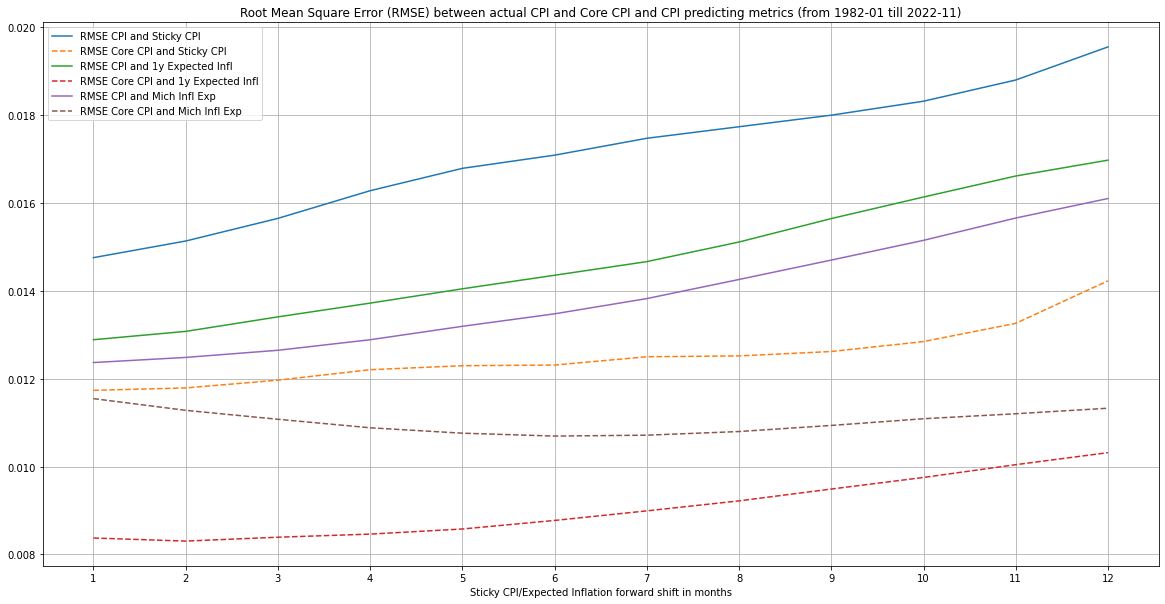

In [9]:
_ = df_cpi_predictors.plot(
        figsize=(20,10), grid=True,
        title='Root Mean Square Error (RMSE) between actual CPI and Core CPI and CPI predicting metrics (from {:%Y-%m} till {:%Y-%m})'
            .format(cpis.index[0].date(), cpis.index[-1].date()),
        xticks=df_cpi_predictors.index, style=['-', '--']*3)

### Conclusion
1. Federal Reserve Bank of Cleveland estimate of 1-Year Expected Inflation is head and shoulders the best predictor of actual Core CPI over the next 12 months. Despite its intent of predicting CPI over the next year, it actually is best at predicting the actual core CPI in 2 months.
2. University of Michigan: Inflation Expectation over the next 12 months is by far the best at predicting the overall CPI ove the next 12 months. Despite its intent of predicing CPI over the next year, it actually is best the most accurate at forecasting it for the following months.

## Limiting the analysis to the last 10 and 5 years
It's interesting to see if the conclusion would be the same if we limit the calculation of RMSE to the last 10 and 5 years.

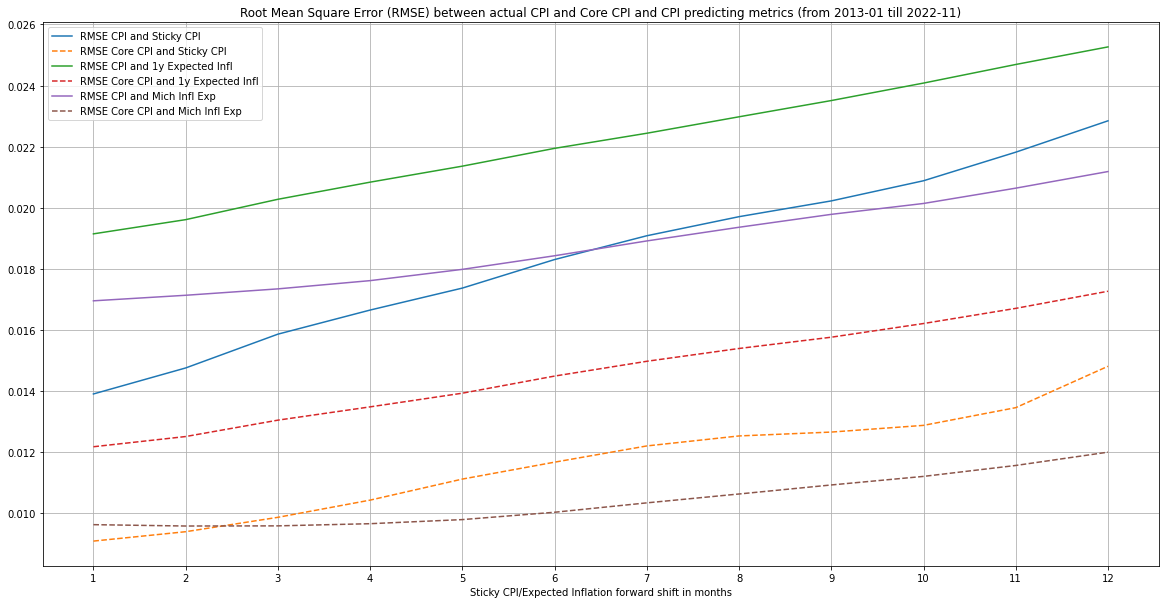

In [10]:
_ = df_cpi_predictors_last_10y.plot(
        figsize=(20,10), grid=True,
        title='Root Mean Square Error (RMSE) between actual CPI and Core CPI and CPI predicting metrics (from {:%Y-%m} till {:%Y-%m})'
            .format(date_for_last_10y, cpis.index[-1].date()),
        xticks=df_cpi_predictors_last_10y.index, style=['-', '--']*3)

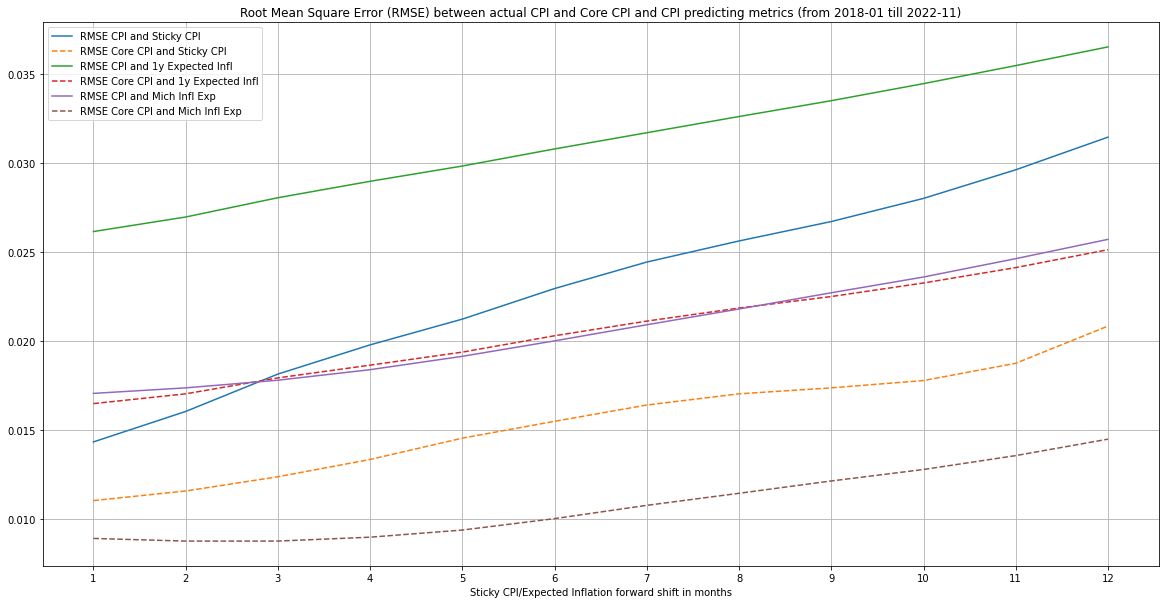

In [11]:
_ = df_cpi_predictors_last_5y.plot(
        figsize=(20,10), grid=True,
        title='Root Mean Square Error (RMSE) between actual CPI and Core CPI and CPI predicting metrics (from {:%Y-%m} till {:%Y-%m})'
            .format(date_for_last_5y, cpis.index[-1].date()),
        xticks=df_cpi_predictors_last_5y.index, style=['-', '--']*3)

### Conclusion 2
The main difference is that when we limit the comparison to the past 10 and 5 years only is that:
1. University of Michigan: Inflation Expectation over the next 12 months is by far the best at predicting the Core CPI as well as overall CPI over the next 12 months (when we take the entire period from 1982 into account this indicator is the best only at predicting the overall CPI).
2. Sticky CPI is doing a better job at predicting both Core CPI as well as the overall CPI at 1 year time horizon than Federal Reserve Bank of Cleveland estimate of 1-Year Expected Inflation.